In [ ]:
pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install torchvision 

In [ ]:
# from transformers import TrOCRProcessor

# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# processor.save_pretrained('./ms-processor')

In [1]:
from transformers import AutoFeatureExtractor, AutoTokenizer
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-384")
decoder_tokenizer = AutoTokenizer.from_pretrained("urduhack/roberta-urdu-small")
processor =TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=decoder_tokenizer)

In [3]:
processor.save_pretrained('./processor')

In [4]:
!pip install -q datasets jiwer

In [2]:
import pandas as pd
import cv2
df = pd.read_csv('all_data/train/labels.csv', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df

,file_name,text
0,0.png,پشاور،بنوں (نمائندہ جنگ،اے ایف پی) بنوں میں اق...
1,1.png,اسکے ساتھ ملحقہ علاقے کے عوام نے بجلی و گیس
2,2.png,کی لوڈشیڈنگ کیخلاف مظاہرہ کیا۔ پولیس تشدد سے ا...
3,3.png,منشور علی جاں بحق اور 2خواتین سمیت 14 افرادزخم...
4,4.png,علاقے میں کرفیو نافذ کردیا گیا ہے۔ مکینوں نے ا...
...,...,...
10058,10058.png,جبکہ حکومت ان متاثرین کی امداد اور دوبارہ بحال...
10059,10059.png,شب و روز کوشاں ہے۔ انہوں نے کہا کہ نقصانات
10060,10060.png,کے سروے کا کام جاری ہے۔ دونوں رہنماؤں نے اس
10061,10061.png,عزم کا اعادہ کیا کہ صوبے کے متاثرہ افراد کی


In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [4]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length",max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [5]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("./processor")
train_dataset = IAMDataset(root_dir='./all_data/train/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='./all_data/train/',
                           df=test_df,
                           processor=processor)

In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 7044
Number of validation examples: 3019


In [8]:
encoding = train_dataset[3]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


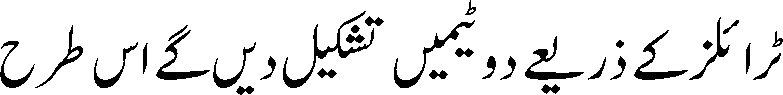

In [15]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][5]).convert("RGB")
image

In [16]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

تھی۔ کامران خان نے بتایا کہ ذوالفقار مرزا نے اجلاس


In [7]:
from transformers import VisionEncoderDecoderModel


model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-384", "urduhack/roberta-urdu-small"
)
# set decoder config to causal lm
model.config.decoder.is_decoder = True
model.config.decoder.add_cross_attention = True
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Downloading:   0%|          | 0.00/348M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/507M [00:00<?, ?B/s]

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at urduhack/roberta-urdu-small and are newly initialized: ['roberta.encoder.layer.11.crossattention.self.key.weight', 'roberta.encoder.layer.11.crossattention.self.value.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.3.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.6.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.4.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.10.crossattention.output.dense.weight', 'roberta.encoder.layer.5.crossattention.self.query.weight', 'roberta.encoder.layer.8.crossattention.self.value.weight', 'roberta.encoder.layer.4.crossattention.self.query.weight', 'roberta.encoder.layer.11.crossattention.self.query.weight', 'roberta.encoder.layer.11.crossattention.output.dense.weight', 'roberta.encoder.layer.9.crossattention.self.value.bias', 'roberta.encoder.layer.6.crossattention.self.query.weight', 

using steps 

In [8]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True, #uncomment this for CPU 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    num_train_epochs=10,  
)

ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation (`--fp16_full_eval`) can only be used on CUDA devices.

evaluating using epoch

In [26]:
training_args = Seq2SeqTrainingArguments(
   evaluation_strategy = "epoch",
   learning_rate=2e-4,
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   weight_decay=0.01,
   save_total_limit=3,
   num_train_epochs=100,
   output_dir="./",
   predict_with_generate=True,  
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [20]:
pip install datasets

  Using cached datasets-2.6.1-py3-none-any.whl (441 kB)
     ---------------------------------------- 19.6/19.6 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 132.3/132.3 kB 2.6 MB/s eta 0:00:00
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: tqdm>=4.62.1 in c:\users\ncl_ncai\anaconda3\lib\site-packages (from datasets) (4.64.0)



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: C:\Users\NCL_NCAI\anaconda3\python.exe -m pip install --upgrade pip


In [22]:
pip install jiwer

  Using cached jiwer-2.5.1-py3-none-any.whl (15 kB)
     ------------------------------------ 182.5/182.5 kB 736.4 kB/s eta 0:00:00
     -------------------------------------- 993.6/993.6 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: C:\Users\NCL_NCAI\anaconda3\python.exe -m pip install --upgrade pip


In [23]:
from datasets import load_metric
cer_metric = load_metric("cer")

In [24]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [27]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
)
trainer.train()

***** Running training *****
  Num examples = 7044
  Num Epochs = 100
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 22100


Epoch,Training Loss,Validation Loss



KeyboardInterrupt



In [59]:
trainer.save_model('./trainer')

Saving model checkpoint to ./trainer
Configuration saved in ./trainer/config.json
Model weights saved in ./trainer/pytorch_model.bin
Feature extractor saved in ./trainer/preprocessor_config.json


In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("./trainer")

In [61]:
image = Image.open('/content/40.png').convert("RGB")

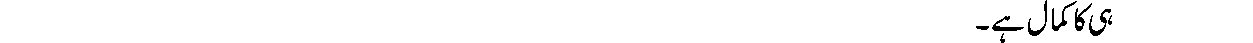

In [62]:
image

In [63]:
pixel_values = processor.feature_extractor(image, return_tensors="pt").pixel_values 
print(pixel_values.shape)

torch.Size([1, 3, 384, 384])


In [64]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

ہی کا کمال ہے
